In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline


In [2]:
# read data cloud
df = pd.read_csv('sonos_all_data-6m\sonoff_bigscreen_dump_2019-08-01-2020-06-08.csv')
# convert epoch time to datetime

df['time'] = pd.to_datetime(df['time']/1000000000,unit='s')
df.head(10)

,name,time,mean_power,mean_current,mean_voltage
0,mqtt_consumer,2019-08-01 00:00:00,NaN,NaN,NaN
1,mqtt_consumer,2019-08-01 00:00:10,NaN,NaN,NaN
2,mqtt_consumer,2019-08-01 00:00:20,NaN,NaN,NaN
3,mqtt_consumer,2019-08-01 00:00:30,NaN,NaN,NaN
4,mqtt_consumer,2019-08-01 00:00:40,NaN,NaN,NaN
5,mqtt_consumer,2019-08-01 00:00:50,NaN,NaN,NaN
6,mqtt_consumer,2019-08-01 00:01:00,NaN,NaN,NaN
7,mqtt_consumer,2019-08-01 00:01:10,NaN,NaN,NaN
8,mqtt_consumer,2019-08-01 00:01:20,NaN,NaN,NaN
9,mqtt_consumer,2019-08-01 00:01:30,NaN,NaN,NaN


In [3]:
df=df.set_index(df['time'])['2019-12-23 00:00:00' :'2020-06-07 23:59:50']
df=df[['time','mean_power']]
df.head()

,time,mean_power
time,,
2019-12-23 00:00:00,2019-12-23 00:00:00,21.0
2019-12-23 00:00:10,2019-12-23 00:00:10,21.0
2019-12-23 00:00:20,2019-12-23 00:00:20,21.0
2019-12-23 00:00:30,2019-12-23 00:00:30,21.0
2019-12-23 00:00:40,2019-12-23 00:00:40,21.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1451520 entries, 2019-12-23 00:00:00 to 2020-06-07 23:59:50
Data columns (total 2 columns):
time          1451520 non-null datetime64[ns]
mean_power    1388456 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.2 MB


In [5]:
# prepare data 
df['time'] = pd.to_datetime(df['time'])
df['weekofyear']=df['time'].dt.week
df['day_name']=df['time'].dt.weekday
df['hour']=df['time'].dt.hour
df['mins']=df['time'].dt.minute

# prepare weekday, weekend, and holiday columns
df['day_type'] = df['day_name'].apply(lambda x: 'weekday' if x <5 else 'weekend')



df['weekofyear']=df['weekofyear'].apply(lambda x:-2 if x==51 else (-1 if x==52 else x) )
df['kWh']=df['mean_power']/1000*1/60*1/60*10
# lockdown
df.loc[df.weekofyear >12, 'day_type'] = 'holiday'
# christmas eve
df.loc[(df.weekofyear== -1) & (df.day_name==1 ) ,'day_type']='holiday'
# christmas
df.loc[(df.weekofyear== -1) & (df.day_name==2 ) ,'day_type']='holiday'
# new year
df.loc[(df.weekofyear== 1) & (df.day_name==2 ) ,'day_type']='holiday'

C:\Users\User\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


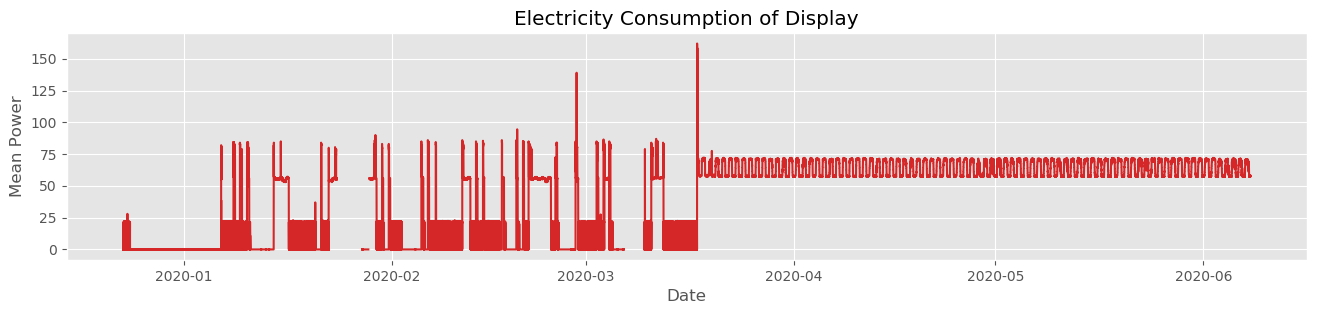

In [6]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Mean Power', dpi=100):
    plt.figure(figsize=(16,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['time'], y=df['mean_power'], title='Electricity Consumption of Display')

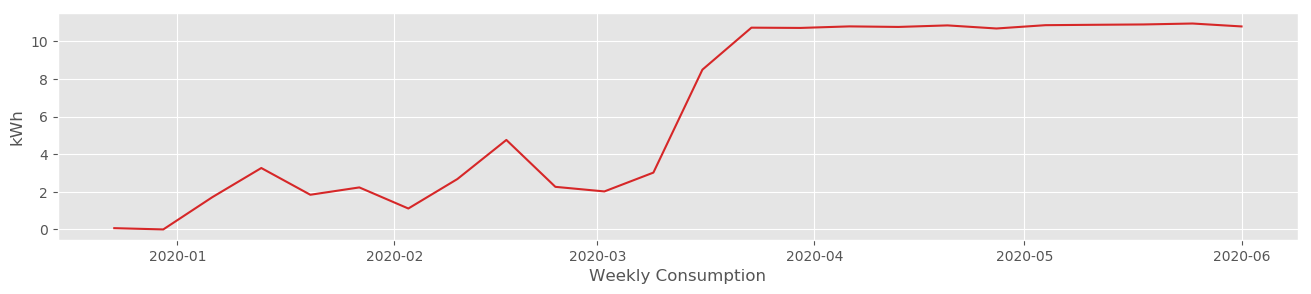

In [7]:
# prepare summed weekly, daily, and hourly patterns
week = pd.DataFrame({'Week_kWh' : (df.groupby( ['weekofyear'])['kWh'].sum())}).reset_index()
# the date is made here by using date_range
week['week_date'] = pd.date_range(start="12/17/2019", end="06/07/2020", freq='W-MON')
plot_df(week, x=week.week_date, y=week.Week_kWh, xlabel='Weekly Consumption',ylabel='kWh', title='') 

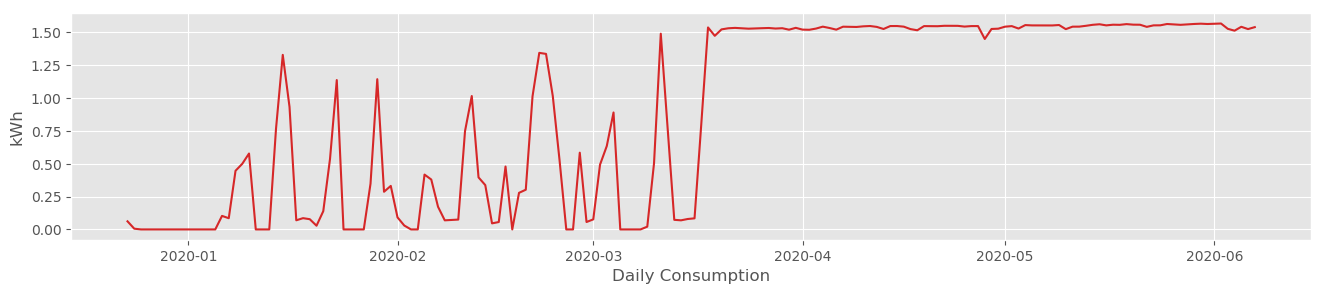

In [8]:
# prepare summed weekly, daily, and hourly patterns
day = pd.DataFrame({'day_kWh' : (df.groupby( ['weekofyear','day_name'])['kWh'].sum())}).reset_index()
day['day_date'] = pd.date_range(start="12/23/2019", end="06/07/2020", freq='D')
plot_df(day, x=day.day_date, y=day.day_kWh, xlabel='Daily Consumption',ylabel='kWh', title='') 

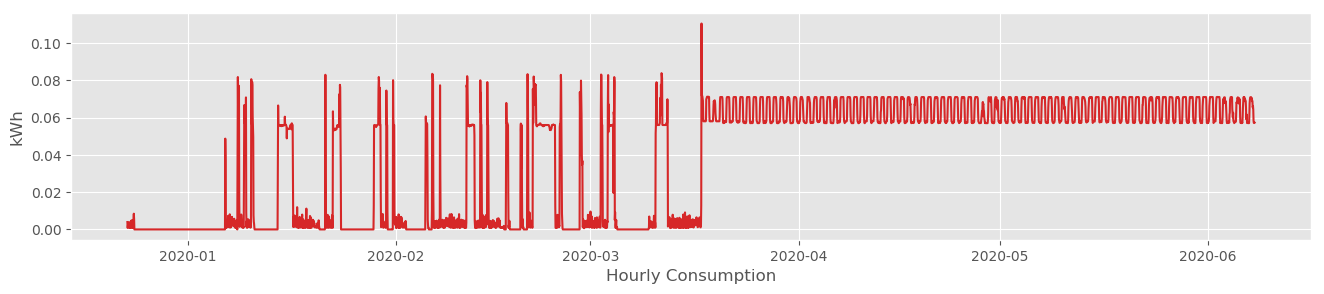

In [9]:
# prepare summed weekly, daily, and hourly patterns
hour = pd.DataFrame({'hour_kWh' : (df.groupby( ['weekofyear','day_name','hour'])['kWh'].sum())}).reset_index()
hour['hour_index'] = pd.date_range(start="12/23/2019", end="06/07/2020 23:00:00", freq='H')
plot_df(hour, x=hour.hour_index, y=hour.hour_kWh, xlabel='Hourly Consumption',ylabel='kWh', title='')

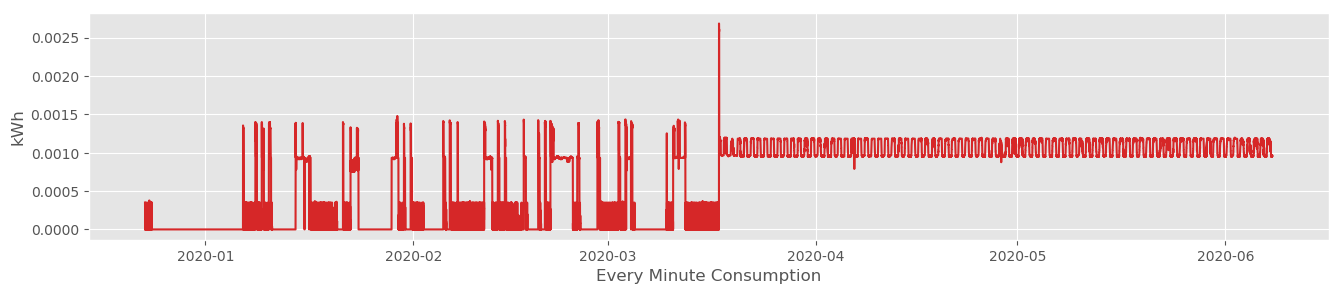

In [10]:
# prepare summed weekly, daily, and hourly patterns
minute = pd.DataFrame({'minute_kWh' : (df.groupby( ['weekofyear','day_name','hour','mins'])['kWh'].sum())}).reset_index()
minute['mins_index'] = pd.date_range(start="12/23/2019", end="06/07/2020 23:59:00", freq='T')
plot_df(minute, x=minute.mins_index, y=minute.minute_kWh, xlabel='Every Minute Consumption',ylabel='kWh', title='') 

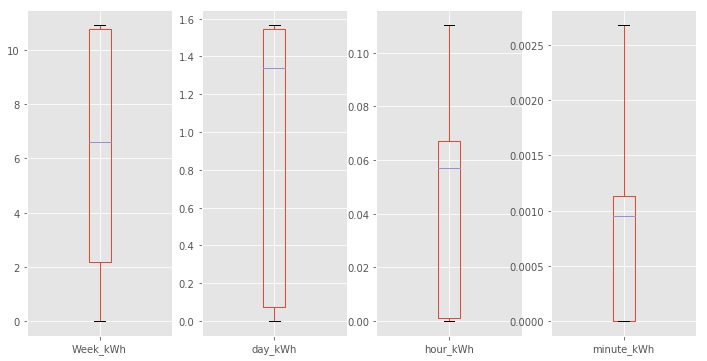

In [11]:
# boxplots of power consumption 
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
weekbp = week.boxplot(column=['Week_kWh'])

plt.subplot(1, 4, 2)
daybp = day.boxplot(column=['day_kWh'])

plt.subplot(1, 4, 3)
hourbp = hour.boxplot(column=['hour_kWh'])

plt.subplot(1, 4, 4)
minsbp = minute.boxplot(column=['minute_kWh'])

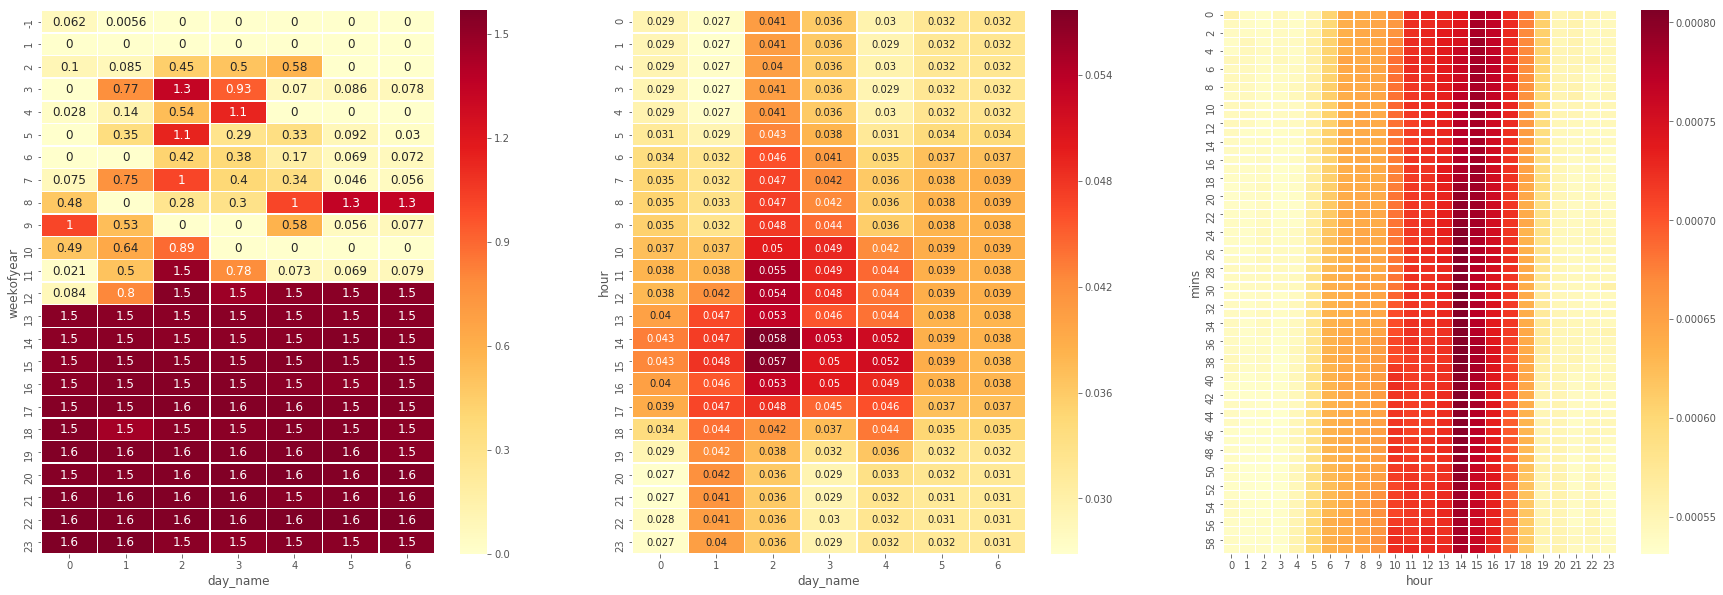

In [12]:
# heatmap of different period time trend

fig = plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
# plot week and day heatmap  
day_pi = day.pivot("weekofyear", "day_name", "day_kWh")
ax0 = sns.heatmap(day_pi, linewidth=0.5, annot=True,cmap="YlOrRd",annot_kws={"size": 12})

plt.subplot(1, 3, 2)
# plot day and hour heatmap  
hour_pi =hour.reset_index().pivot_table("hour_kWh", "hour","day_name" )
ax1 = sns.heatmap(hour_pi,linewidth=0.5 ,cmap="YlOrRd",annot=True,annot_kws={"size": 10})

plt.subplot(1, 3, 3)
# plot hour and minute heatmap
mins_pi =minute.reset_index().pivot_table( "minute_kWh", "mins","hour")
ax2 = sns.heatmap(mins_pi,linewidth=0.5 ,cmap="YlOrRd",annot=False,annot_kws={"size": 8})

In [15]:
# impute the first week missing data
df['kWh'].fillna(method='ffill',limit=275, inplace=True)

In [16]:
# assum missing value would be as normal pattern before lockdown, so replace the value same as the week before 
import math
for i in range(0,725760):
    if math.isnan(float(df['kWh'][i])):
        df['kWh'][i]= df['kWh'][i-60480]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [17]:
# assum missing value would be as normal pattern after lockdown, so replace the value same as the week before 
for i in range(725760,len(df)):
    if math.isnan(float(df['kWh'][i])):
        df['kWh'][i]= df['kWh'][i+60480]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1451520 entries, 2019-12-23 00:00:00 to 2020-06-07 23:59:50
Data columns (total 7 columns):
mean_power    1388456 non-null float64
weekofyear    1451520 non-null int64
day_name      1451520 non-null int64
hour          1451520 non-null int64
mins          1451520 non-null int64
day_type      1451520 non-null object
kWh           1451520 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 88.6+ MB


In [21]:
df1=df[['mean_power','weekofyear','day_name','hour','mins','day_type','kWh']]
# using sqlite as the database 
from sqlalchemy import create_engine
engine = create_engine('sqlite:///dissertation.db', echo=True) #set the database name as jba.db
sqlite_connection = engine.connect()
sqlite_table = "display"       #set the table name as rainfall_data
df.to_sql(sqlite_table, sqlite_connection, if_exists='replace')  # import dataframe to sqlite

2020-07-27 06:53:17,021 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-07-27 06:53:17,026 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:53:17,032 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-07-27 06:53:17,034 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:53:19,046 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("display")
2020-07-27 06:53:19,047 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:53:19,054 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE display (
	time DATETIME, 
	mean_power FLOAT, 
	weekofyear BIGINT, 
	day_name BIGINT, 
	hour BIGINT, 
	mins BIGINT, 
	day_type TEXT, 
	"kWh" FLOAT
)


2020-07-27 06:53:19,058 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:53:19,378 INFO sqlalchemy.engine.base.Engine COMMIT
2020-07-27 06:53:19,380 INFO sqlalchemy.engine.base.Engine CREATE INDEX ix_display_time ON display (time)
2020-07-27 06:53:19,380 INFO s

In [19]:
sqlite_connection.close() # close the connection

In [ ]:
df_engineering= df.copy()

In [ ]:
week.describe()

In [14]:
subset1=df['2019-12-30 00:00:00':'2020-01-06 00:00:00']
subset1.loc[subset1['kWh'].isna()]

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
time,,,,,,,,
2019-12-30 00:19:10,2019-12-30 00:19:10,NaN,1,0,0,19,weekday,NaN
2019-12-30 02:55:40,2019-12-30 02:55:40,NaN,1,0,2,55,weekday,NaN
2019-12-30 03:40:40,2019-12-30 03:40:40,NaN,1,0,3,40,weekday,NaN
2019-12-30 03:46:00,2019-12-30 03:46:00,NaN,1,0,3,46,weekday,NaN
2019-12-30 05:21:20,2019-12-30 05:21:20,NaN,1,0,5,21,weekday,NaN
2019-12-30 05:23:50,2019-12-30 05:23:50,NaN,1,0,5,23,weekday,NaN
2019-12-30 05:24:00,2019-12-30 05:24:00,NaN,1,0,5,24,weekday,NaN
2019-12-30 05:24:10,2019-12-30 05:24:10,NaN,1,0,5,24,weekday,NaN
2019-12-30 05:24:20,2019-12-30 05:24:20,NaN,1,0,5,24,weekday,NaN


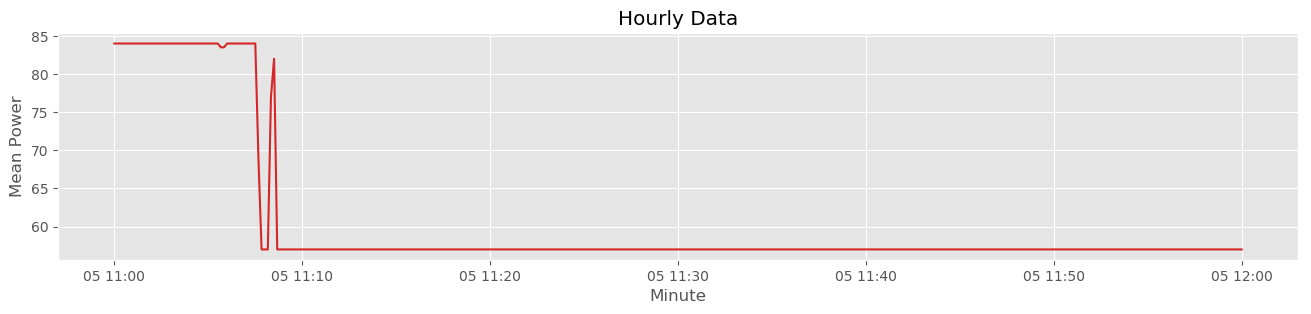

In [7]:
hourly_df = df.set_index(df['time'])['2020-02-05 11:00:00' :'2020-02-05 12:00:00']
plot_df(hourly_df, x=hourly_df.time, y=hourly_df.mean_power, xlabel='Minute',ylabel='Mean Power', title='Hourly Data') 

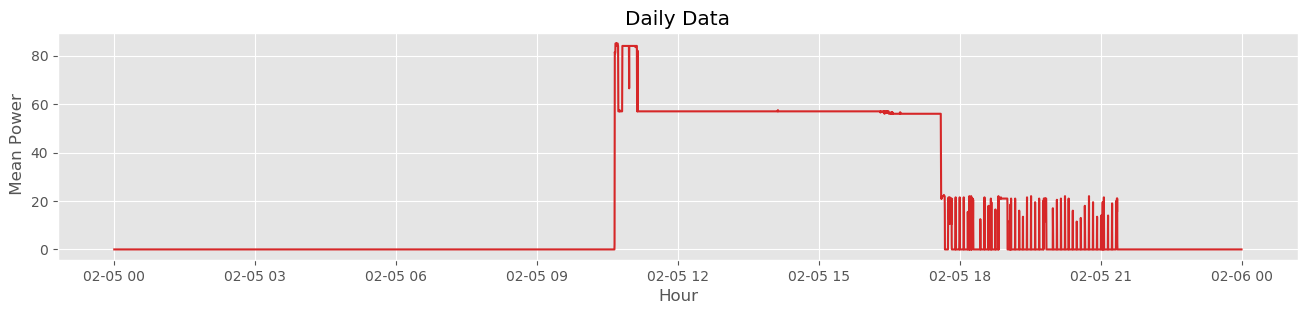

In [8]:
daily_df=df.set_index(df['time'])['2020-02-05 00:00:00' :'2020-02-05 23:59:50']

plot_df(daily_df, x=daily_df.time, y=daily_df.mean_power, xlabel='Hour',ylabel=' Mean Power', title='Daily Data') 

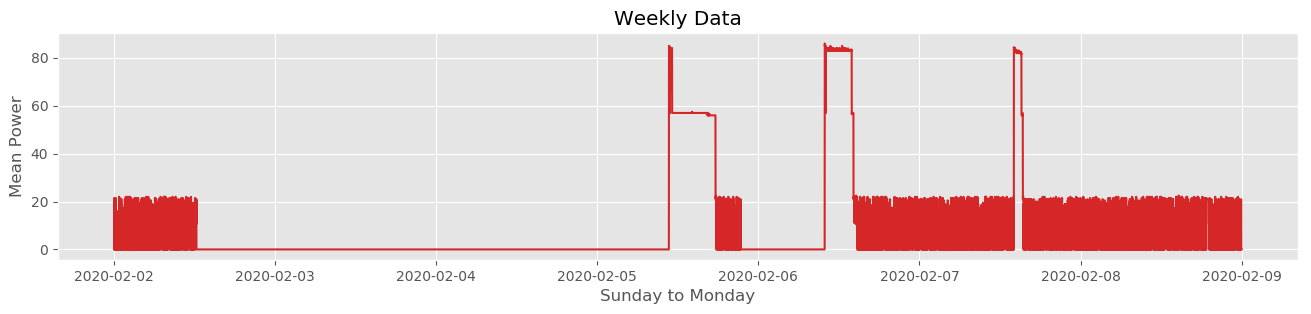

In [9]:
weekly_df=df.set_index(df['time'])['2020-02-02 00:00:00' :'2020-02-08 23:59:50']

plot_df(weekly_df, x=weekly_df.time, y=weekly_df.mean_power, xlabel='Sunday to Monday',ylabel='Mean Power', title='Weekly Data')

In [12]:
# prepare hour data
df['Hour']=df['time'].dt.hour

# prepare weekday, weekend, and holiday columns
df['day_type'] = df['day_name'].apply(lambda x: 'weekend' if (x == 'Sunday' or x == 'Saturday') else 'weekday')
df['kWh']=df['mean_power']/1000*1/60*1/60*10

df.loc[df['weekofyear']==4]

,index,name,time,mean_power,mean_current,mean_voltage,day_name,weekofyear,Hour,day_type,kWh
261285,1486080,mqtt_consumer,2020-01-20 00:00:00,10.5,0.078500,240.500000,Monday,4,0,weekday,0.000029
261286,1486081,mqtt_consumer,2020-01-20 00:00:10,15.5,0.105000,240.500000,Monday,4,0,weekday,0.000043
261287,1486082,mqtt_consumer,2020-01-20 00:00:20,0.0,0.007500,241.000000,Monday,4,0,weekday,0.000000
261288,1486083,mqtt_consumer,2020-01-20 00:00:30,0.0,0.000000,241.000000,Monday,4,0,weekday,0.000000
261289,1486084,mqtt_consumer,2020-01-20 00:00:40,0.0,0.000000,240.000000,Monday,4,0,weekday,0.000000
261290,1486085,mqtt_consumer,2020-01-20 00:00:50,0.0,0.000000,241.000000,Monday,4,0,weekday,0.000000
261291,1486086,mqtt_consumer,2020-01-20 00:01:00,0.0,0.000000,240.000000,Monday,4,0,weekday,0.000000
261292,1486087,mqtt_consumer,2020-01-20 00:01:10,13.0,0.086000,240.000000,Monday,4,0,weekday,0.000036
261293,1486088,mqtt_consumer,2020-01-20 00:01:20,18.5,0.111500,239.500000,Monday,4,0,weekday,0.000051
261294,1486089,mqtt_consumer,2020-01-20 00:01:30,0.0,0.000000,240.500000,Monday,4,0,weekday,0.000000


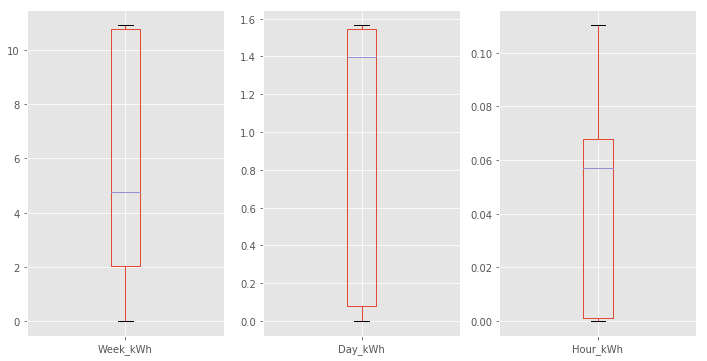

In [11]:
# boxplots of power consumption 
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
week = pd.DataFrame({'Week_kWh' : (df.groupby( ['weekofyear'])['kWh'].sum())}).reset_index()

weekbp = week.boxplot(column=['Week_kWh'])

plt.subplot(1, 3, 2)
day = pd.DataFrame({'Day_kWh' : (df.groupby( ['weekofyear','day_name'])['kWh'].sum()),'day_sdv':(df.groupby( ['weekofyear','day_name'])['kWh'].std())}).reset_index()
daybp = day.boxplot(column=['Day_kWh'])

plt.subplot(1, 3, 3)
hour = pd.DataFrame({'Hour_kWh' : (df.groupby( ['weekofyear','day_name','Hour'] )['kWh'].sum()),'hour_sdv':(df.groupby( ['weekofyear','day_name','Hour'])['kWh'].std())}).reset_index()
hourbp = hour.boxplot(column=['Hour_kWh'])